In [29]:
import pandas, numpy, matplotlib.pyplot as plt, seaborn, datetime

In [3]:
# Parametros Gerais 
seaborn.set(rc={'figure.figsize':(11, 4)})

In [14]:
# Parâmetros para dados

DATA_PATH = "../Data/all_month.csv"

relevantAttributes = ["depth","mag","latitude","longitude", "nst", "gap", "rms"]

FAULT_DATE          = "2020-04-12"
SAMPLING_FREQUENCY  = "90T" # 90 minutos
TIME_BEFORE_FAULT   = "7D"
TIME_AFTER_FAULT    = "1D"


In [34]:
# Processa os dias de interesse
faultDate = pandas.to_datetime("2020-04-12")
startDate = faultDate - pandas.to_timedelta(TIME_BEFORE_FAULT)
endDate   = faultDate + pandas.to_timedelta(TIME_AFTER_FAULT)

#print(startDate,faultDate,endDate)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [21]:
# Carrega dados
df = pandas.read_csv(DATA_PATH)

In [22]:
# Organização dados
df.time = pandas.to_datetime(df.time)
df.set_index('time', inplace=True)
df.sort_index(inplace=True)
df = df[relevantAttributes]

,depth,mag,latitude,longitude,nst,gap,rms
time,,,,,,,
2020-03-22 13:45:09.360000+00:00,22.51,0.98,47.721167,-121.973833,15.0,68.00,0.1200
2020-03-22 13:49:33.280000+00:00,1.83,1.18,38.819167,-122.779167,36.0,32.00,0.0500
2020-03-22 13:51:06.482000+00:00,10.60,0.60,39.112500,-119.720100,5.0,135.53,0.1121
2020-03-22 13:59:47.610000+00:00,9.61,1.68,45.372833,-112.583000,16.0,135.00,0.0800
2020-03-22 14:00:28.850000+00:00,1.12,1.82,36.053665,-117.709503,27.0,53.00,0.1600
...,...,...,...,...,...,...,...
2020-03-25 23:24:53.680000+00:00,5.00,0.37,45.870000,-111.370000,5.0,115.00,0.2400
2020-03-25 23:32:45.630000+00:00,6.51,1.61,35.800500,-117.625000,18.0,87.00,0.1100
2020-03-25 23:33:24.110000+00:00,12.00,2.61,17.919600,-66.805800,19.0,198.00,0.2000


In [47]:
def pythonDatetimeToString(datetimeValue):
    return datetimeValue.strftime("%Y-%m-%d %H:%M:%S")
def pandasDatetimeToString(datetimeValue):
    return datetimeValue.to_pydatetime().strftime("%Y-%m-%d %H:%M:%S")


'2020-04-12 00:00:00'

In [82]:
#df.loc['2020-04'].plot(subplots=True)
resampledDf = df[startDate.to_pydatetime().strftime("%Y-%m-%d %H:%M:%S"):endDate.to_pydatetime().strftime("%Y-%m-%d %H:%M:%S")].resample(SAMPLING_FREQUENCY).mean()
# resampledDf.plot(subplots=True)

In [83]:
# Cria uns Fake outlier
resampledDf[pandasDatetimeToString(faultDate):]["mag"]=resampledDf[pandasDatetimeToString(faultDate):]["mag"]+2
resampledDf[pandasDatetimeToString(faultDate):]["depth"]=resampledDf[pandasDatetimeToString(faultDate):]["depth"]-15

#resampledDf.shape
#resampledDf.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f11d4323790>,
      dtype=object)

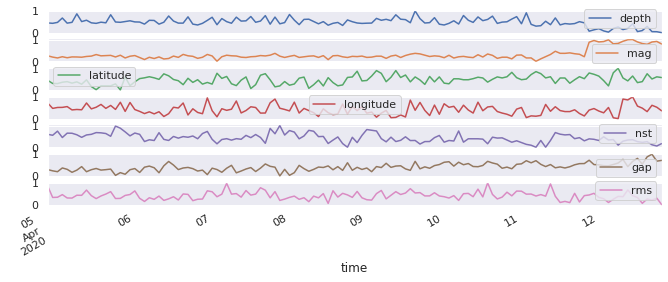

In [84]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
resampledDf[resampledDf.columns] = scaler.fit_transform(resampledDf[resampledDf.columns])
#resampledDf.plot(subplots=True)

In [85]:
y = numpy.transpose(resampledDf.values)
x = [a for a in range(0,len(y))]


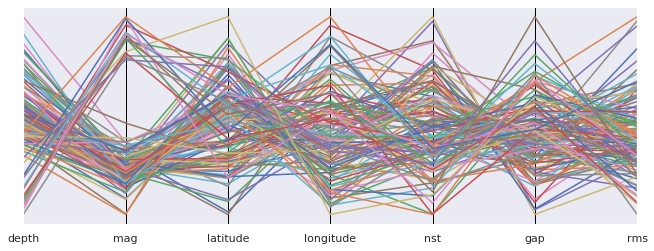

In [86]:
# cria a figura 
fig = plt.figure()
ax = plt.gca()

# Eixos verticais
for i in x:
    ax.axvline(i, linewidth=1, color='black')

# Nome/posição dos atributos nos eixos
ax.set_xticks(x)
ax.set_xticklabels(relevantAttributes)

# Remove marcações no eixo Y
ax.set_yticks([])

# Remove margens
ax.set_xlim(x[0], x[-1])

plt.plot(x,y)